<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.30.1

numpy      : 1.22.0
scipy      : 1.7.3
pandas     : 1.5.2
matplotlib : 3.5.1
statsmodels: 0.13.5
sklearn    : 0.0

Compiler    : MSC v.1927 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Git hash: 



In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max.columns', 25)
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users_s15_w10_max1.0_min1.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users_s15_w10_max1.0_min1.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14060, 4008)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [10]:
knn_pred_split = knn.fit(X_train, y_train).predict(X_valid)
knn_score_split = accuracy_score(y_valid, knn_pred_split)

ValueError: indices and data should have the same size

In [ ]:
knn_score_cv = cross_val_score(knn, X_train, y_train, cv=skf).mean()

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [ ]:
print(f'{knn_score_cv:.3f} {knn_score_split:.3f}')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
forest = RandomForestClassifier(random_state=17, oob_score=True, n_jobs=-1)

In [13]:
forest_pred_split = forest.fit(X_train, y_train).predict(X_valid)
forest_score_split = accuracy_score(y_valid, forest_pred_split)

In [14]:
forest_score_cv = cross_val_score(forest, X_train, y_train, cv=skf).mean()

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [15]:
print(f'{forest_score_cv:.3f} {forest_score_split:.3f}')

0.760 0.783


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [16]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [17]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [18]:
logit_score_cv = np.mean(cross_val_score(logit, X_train, y_train, cv=skf))
logit_pred_split = logit.fit(X_train, y_train).predict(X_valid)
logit_score_split = accuracy_score(y_valid, logit_pred_split)

In [19]:
print(f'{logit_score_cv:.3f} {logit_score_split:.3f}')

0.808 0.826


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [20]:
%%time

logit_c_values1 = np.logspace(1e-4, 1e2, 10)

logit_grid_searcher1 = GridSearchCV(logit, param_grid = {"C": logit_c_values1}, cv=skf, return_train_score=True)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 25.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LogisticRegression(n_jobs=-1, random_state=17),
             param_grid={'C': array([1.00023029e+000, 1.29181404e+011, 1.66839930e+022, 2.15476543e+033,
       2.78291537e+044, 3.59418146e+055, 4.64194510e+066, 5.99514926e+077,
       7.74283492e+088, 1.00000000e+100])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [21]:
logit_grid_searcher1.best_score_, logit_grid_searcher1.best_params_

(0.8097947842096526, {'C': 129181403900.30573})

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [22]:
%%time

logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = GridSearchCV(logit, param_grid = {"C": logit_c_values2}, cv=skf, return_train_score=True)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 42.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LogisticRegression(n_jobs=-1, random_state=17),
             param_grid={'C': array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [23]:
logit_grid_searcher2.best_score_, logit_grid_searcher2.best_params_

(0.8099976026047978, {'C': 4.094736842105263})

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [24]:
logit = LogisticRegression(random_state=17, C=4.0947, n_jobs=-1)
logit_score_cv = np.mean(cross_val_score(logit, X_train, y_train, cv=skf))

In [25]:
logit_pred_split = logit.fit(X_train, y_train).predict(X_valid)
logit_score_split = accuracy_score(y_valid, logit_pred_split)

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [26]:
print(f'{logit_score_cv:.3f} {logit_score_split:.3f}')

0.809 0.831


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [27]:
from sklearn.svm import LinearSVC

In [28]:
svm = LinearSVC(C=1, random_state=17)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [29]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 27.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [30]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.7448690167334467, {'C': 10000.0})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

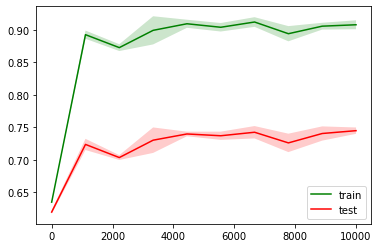

In [31]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [32]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [33]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.8090830304066529, {'C': 0.13879310344827586})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

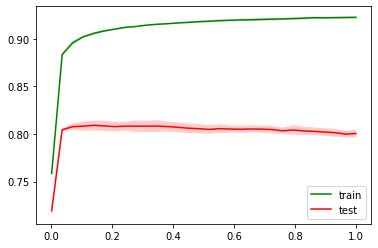

In [34]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [35]:
svm_score_cv = np.mean(cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, cv=skf))
svm_score_split = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.fit(X_train, y_train).predict(X_valid))

In [36]:
print(f'{svm_score_cv:.3f} {svm_score_split:.3f}')

0.809 0.830


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [37]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):

    with open(path_to_X_pickle, 'rb') as fx: X = pickle.load(fx)
    with open(path_to_y_pickle, 'rb') as fy: y = pickle.load(fy)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y)

    estimator_score_cv = np.mean(cross_val_score(estimator, X_train, y_train, cv=cv))
    estimator_score_split = accuracy_score(y_test, estimator.fit(X_train, y_train).predict(X_test))

    return estimator_score_cv, estimator_score_split

**Убедитесь, что функция работает.**

In [38]:
model_assessment(svm_grid_searcher2.best_estimator_,
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w10_max1.0_min1.pkl'),
                 os.path.join(PATH_TO_DATA, 'y_10users_s15_w10_max1.0_min1.pkl'), skf, random_state=17, test_size=0.3)

(0.8090830304066529, 0.8314366998577525)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10.

In [63]:
%%time
estimator = svm_grid_searcher2.best_estimator_

best_score_cv = 0
best_score_split = 0

for window_size, session_length, max_df, min_df in \
    itertools.product([10, 7, 5], [15, 10, 7, 5], [1.0, 0.85, 0.7], [0.01, 10, 5, 1]):
    if window_size <= session_length and (window_size, session_length) != (10, 10):
        path_to_X_pkl = \
            os.path.join(PATH_TO_DATA, f'X_sparse_10users_s{session_length}_w{window_size}_max{max_df}_min{min_df}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_10users_s{session_length}_w{window_size}_max{max_df}_min{min_df}.pkl')

        score_cv, score_split = model_assessment(estimator=svm_grid_searcher2.best_estimator_,
                                                 path_to_X_pickle=path_to_X_pkl,
                                                 path_to_y_pickle=path_to_y_pkl,
                                                 cv=skf)

        print(f"Parameters: window_size: {window_size}, session_length: {session_length}, max_df: {max_df}, min_df: {min_df}")
        print(f"Scores: cv: {score_cv}, split: {score_split}")
        print()

Parameters: window_size: 10, session_length: 15, max_df: 1.0, min_df: 0.01
Scores: cv: 0.6379803153410992, split: 0.6422475106685633

Parameters: window_size: 10, session_length: 15, max_df: 1.0, min_df: 10
Scores: cv: 0.7616339022655693, split: 0.7655286865813181

Parameters: window_size: 10, session_length: 15, max_df: 1.0, min_df: 5
Scores: cv: 0.7913026280902858, split: 0.8032242769084874

Parameters: window_size: 10, session_length: 15, max_df: 1.0, min_df: 1
Scores: cv: 0.8085749003253518, split: 0.8311996206733049

Parameters: window_size: 10, session_length: 15, max_df: 0.85, min_df: 0.01
Scores: cv: 0.6379803153410992, split: 0.6422475106685633

Parameters: window_size: 10, session_length: 15, max_df: 0.85, min_df: 10
Scores: cv: 0.7616339022655693, split: 0.7655286865813181

Parameters: window_size: 10, session_length: 15, max_df: 0.85, min_df: 5
Scores: cv: 0.7913026280902858, split: 0.8032242769084874

Parameters: window_size: 10, session_length: 15, max_df: 0.85, min_df: 1

Лучшие результаты:

Parameters: window_size: 5, session_length: 15, max_df: 1.0, min_df: 1
Scores: cv: 0.8555966567038785, split: 0.8680654338549075

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [39]:
%%time

score_cv, score_split = model_assessment(estimator=svm_grid_searcher2.best_estimator_,
                                         path_to_X_pickle=os.path.join(PATH_TO_DATA,
                                                                       'X_sparse_150users_s15_w5_max1.0_min1.pkl'),
                                         path_to_y_pickle=os.path.join(PATH_TO_DATA,
                                                                       'y_150users_s15_w5_max1.0_min1.pkl'),
                                         cv=skf, random_state=17, test_size=0.3)

Wall time: 15min 16s


In [40]:
print(f'{score_cv:.3f} {score_split:.3f}')

0.586 0.605


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [42]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users_s15_w5_max1.0_min1.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users_s15_w5_max1.0_min1.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [43]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [44]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.best_params_['C']], multi_class='ovr',
                                         n_jobs=-1, random_state=17, cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 7min 21s


LogisticRegressionCV(Cs=[4.094736842105263],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [45]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 0, CV score: 0.9971160515460155
User 1, CV score: 0.9972464289625608
User 2, CV score: 0.9964067984000083
User 3, CV score: 0.994169521932089
User 4, CV score: 0.9917445019843442
User 5, CV score: 0.9951447450078487
User 6, CV score: 0.9943364050252672
User 7, CV score: 0.9868318809289129
User 8, CV score: 0.9974185271524009
User 9, CV score: 0.9963911531100229
User 10, CV score: 0.9956088886107505
User 11, CV score: 0.9942060276087217
User 12, CV score: 0.9971264817393392
User 13, CV score: 0.9953377035843358
User 14, CV score: 0.9968344363262772
User 15, CV score: 0.9966779834264229
User 16, CV score: 0.9919478907541551
User 17, CV score: 0.9951551752011724
User 18, CV score: 0.9950821638479069
User 19, CV score: 0.9928344571866639
User 20, CV score: 0.983645456868543
User 21, CV score: 0.9975123988923134
User 22, CV score: 0.9959739453770776
User 23, CV score: 0.9919896115274497
User 24, CV score: 0.9964067984000083
User 25, CV score: 0.9956297489973976
User 26, CV score: 0.995

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [49]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (sum(class_distr) - class_distr[user_id])/sum(class_distr)

In [50]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [51]:
print(num_better_than_default)

149


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [52]:
y_binary_128 = [int(id == 128) for id in y_150users]

In [53]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes,
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right')

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [54]:
%%time

train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128,
                                              train_sizes=train_sizes, n_jobs=-1, cv=skf)

Wall time: 6.94 s


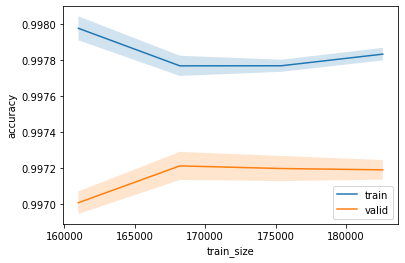

In [55]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**